## Introduction to the project
Cars 4 You is an online car resale company that sells cars from multiple different brands.

Main goal -> expedite the evaluation process by creating a predictive model capable of evaluating the price of a car based on the user’s input without needing the car to be taken to a mechanic.

## Tasks and Evaluations

1. Import the dataset and explore the data (3 points):
   
   a. Check data contents, provide descriptive statistics and check for inconsistencies in the data.
   
   b. Explore data visually and extract relevant insights. Explain your rationale and findings. Do not forget to analyse multivariate relationships.

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from rapidfuzz import process, fuzz
import re
import numpy as np
from typing import Sequence, Mapping, Optional

# Encoding and Scaling
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import category_encoders as ce

#wrapper methods and embedded methods 
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV, RFE

# Cross validation and splitting the data
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Linear regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet

#Evaluation metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Import train, test and samples submission data

train_car_data = pd.read_csv('/Users/diogotiberio/Documents/Mestrado Ciência de Dados IMS/1º Semestre/Machine Learning/Projeto/project_data/train.csv')

test_car_data = pd.read_csv('/Users/diogotiberio/Documents/Mestrado Ciência de Dados IMS/1º Semestre/Machine Learning/Projeto/project_data/test.csv')

sample_submission_car_data = pd.read_csv('/Users/diogotiberio/Documents/Mestrado Ciência de Dados IMS/1º Semestre/Machine Learning/Projeto/project_data/sample_submission.csv')

In this stage we are only going to use the train dataset. First we are going to check for data contents, descriptive statistics, check for inconsistancies and plot the data to extract relevant insights. 

In [3]:
train_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


The training dataset has 75973 entries and 14 columns There are some features with a significant fewer amount of entries: tax and mpg (we need to check for missing data and ways to repalce thoses missing data) the carID column is going to be discarded or set as an index.

In [4]:
# check the train_car_data for descriptive statistcs:
train_car_data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carID,75973.0,NaN,NaN,NaN,37986.0,21931.660338,0.0,18993.0,37986.0,56979.0,75972.0
Brand,74452,72,Ford,14808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,74456,735,Focus,6353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,74482.0,NaN,NaN,NaN,2017.096611,2.208704,1970.0,2016.0,2017.0,2019.0,2024.121759
price,75973.0,NaN,NaN,NaN,16881.889553,9736.926322,450.0,10200.0,14699.0,20950.0,159999.0
transmission,74451,40,Manual,38050,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,74510.0,NaN,NaN,NaN,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.0
fuelType,74462,34,Petrol,37995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tax,68069.0,NaN,NaN,NaN,120.329078,65.521176,-91.12163,125.0,145.0,145.0,580.0
mpg,68047.0,NaN,NaN,NaN,55.152666,16.497837,-43.421768,46.3,54.3,62.8,470.8


From the descriptive statistics in the train data: The first thing we see is that all of the statistics in the hasDamage column are 0. This means that the cars have no damage, and this columns doesn't give significant information to the model so it can be discarted Regarding the price, the max value (159999.000000) is sgnificantly higher that the 75th percentile (Q3 -> 20950.000000), this indicates the presence of outliers The same thing happens to the millage (Q3 -> 32427.500000 and max -> 323000.000000). Furthermore, the min value is negative, which is not possible because we can have negative milage (-58540.574478) In the tax, mpg and previousOwners we also have negative minimum values (not possible), this also means we have outliers in these columns

### Training data Visualization

#### Numeric Variables 
-> Histograms to see the distribuition and to make decision on how to replace the missing values (if we replace them with the mean or the median)

-> Boxplots to see the presence of outliers that should be removed because they affect the linear regression models prediction

-> Scatter plots to see the correlation between numerical features

In [8]:
numerical_data = train_car_data.select_dtypes(include=["int64", "float64"]).drop("carID", axis=1)
numerical_col = numerical_data.columns

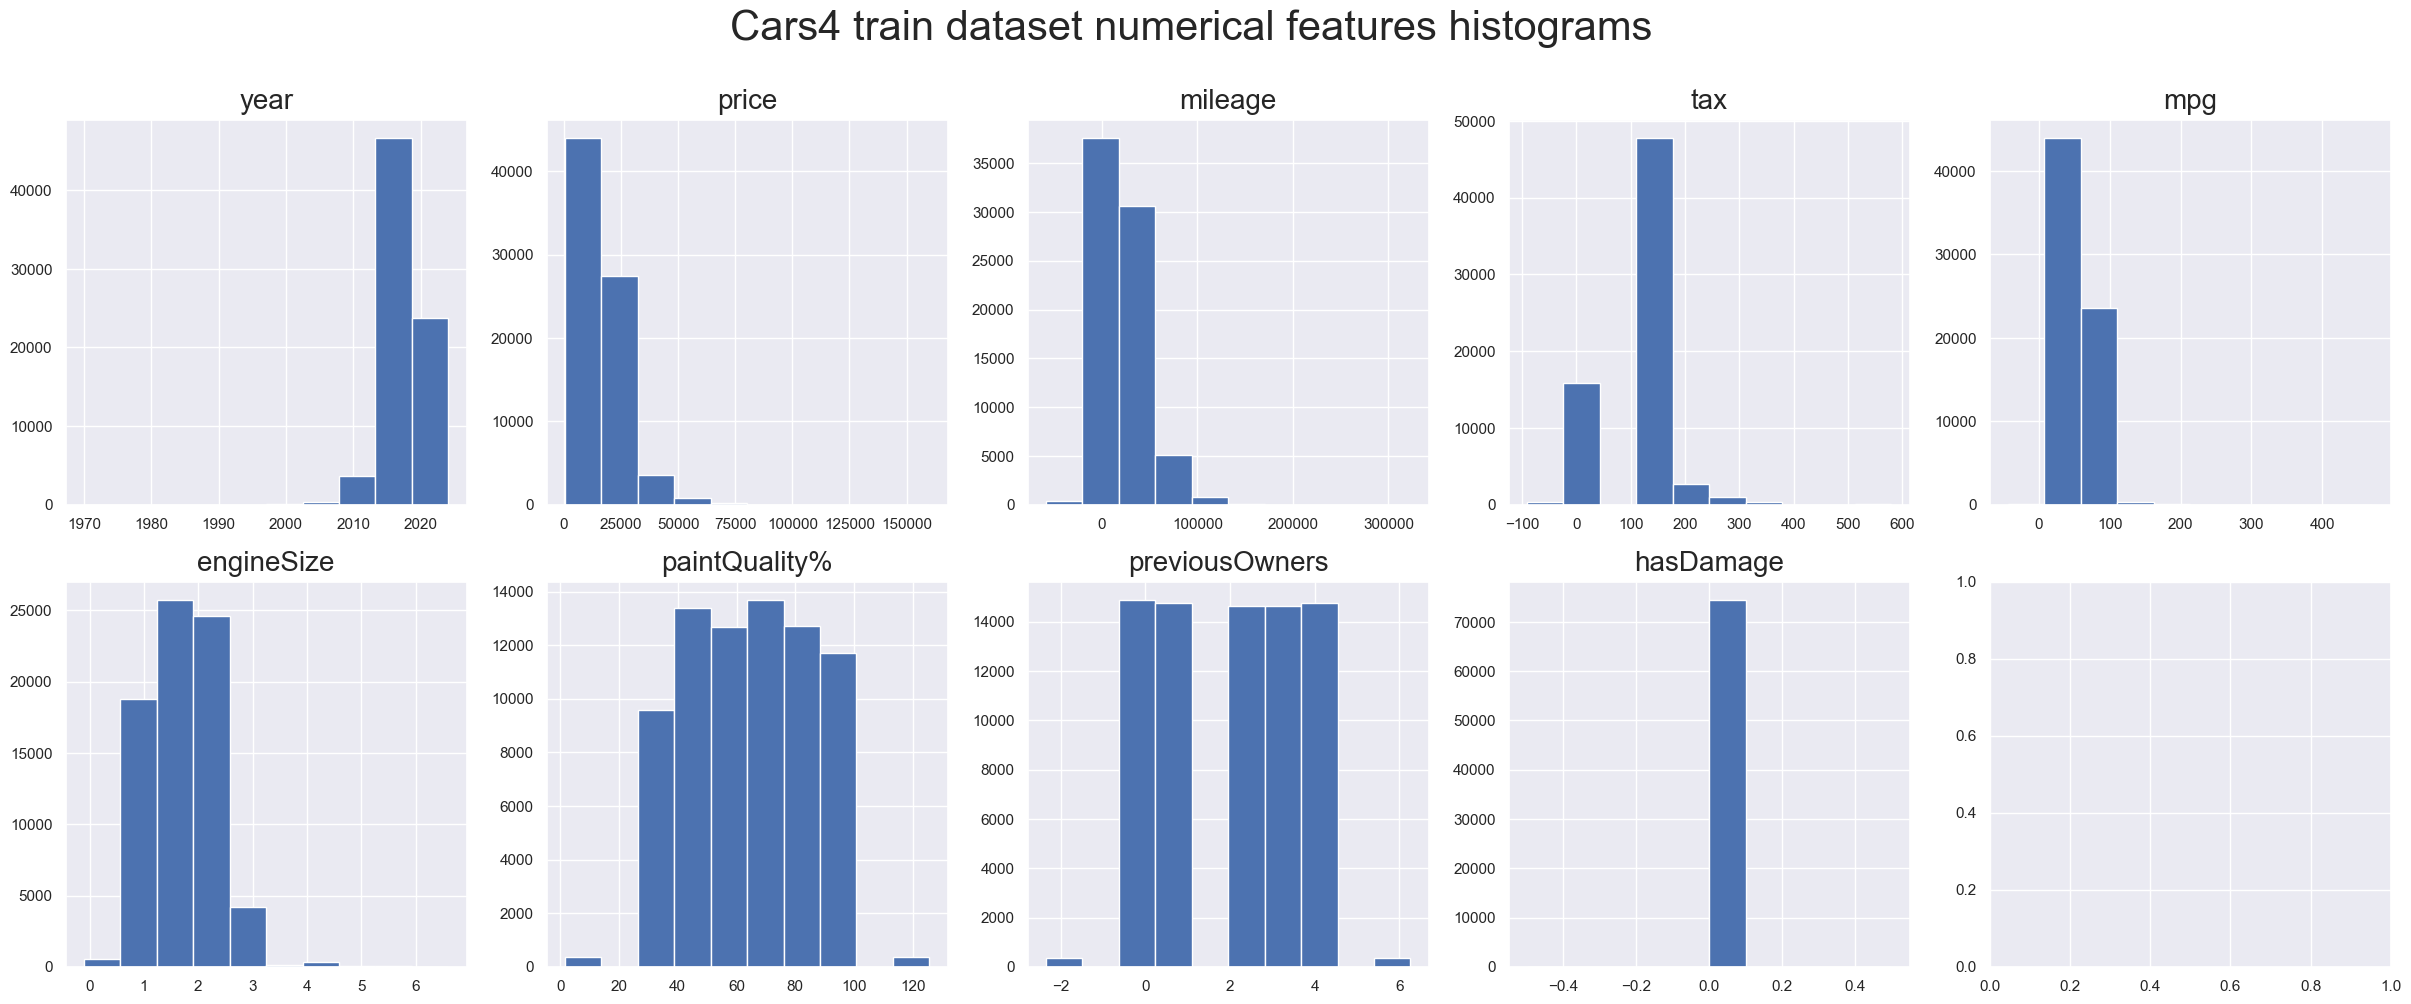

In [9]:
# Histogram 

sns.set()

# create individual axes for each one of the histograms 
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 11)) 

for ax, feature in zip(axes.flatten(), numerical_col):
    ax.hist(numerical_data[feature], bins=10) # we set the number of bins to 10 to see the distribution better
    ax.set_title(feature, fontsize=20, pad=8)

plt.suptitle("Cars4 train dataset numerical features histograms", fontsize=30)
plt.show()

From the histograms of numerical features we can see that price, mileage, tax, mpg and engineSize are skeweed to the right, whereas year is skeweed to the left. In all of this cases we are going to use the median as the statictics to fill the missing data in these columns, because the median is less sensitive to outliers that the mean. Regarding the other 3 features, for paintQuality% and previousOwners we can use the mean, because they seem to follow a more normal distribution and the hasDamage feature we can repalce the missing values with zero, since all the values are zero (also seen in the descriptive statistics).

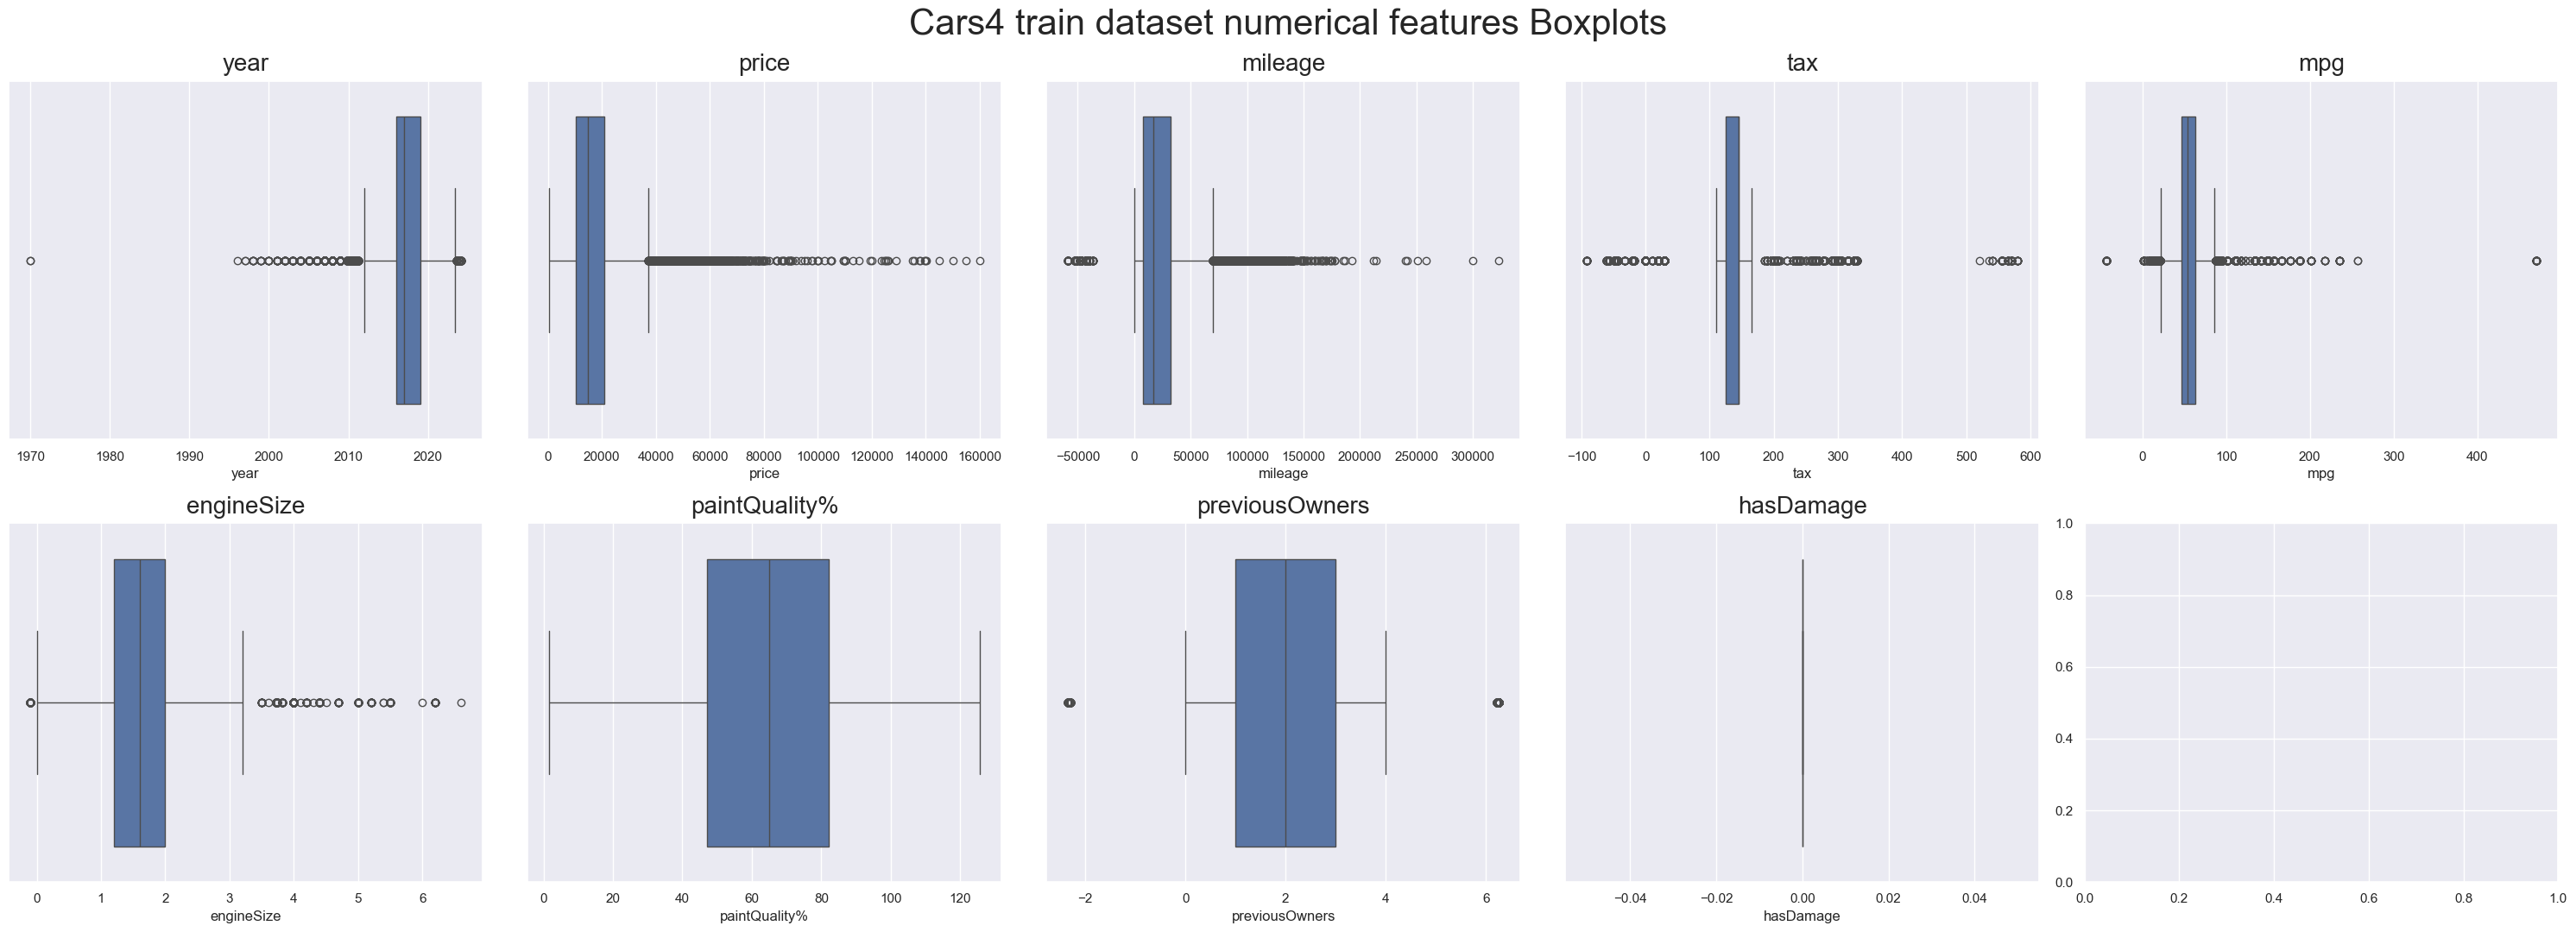

In [10]:
# boxplot 

sns.set()

# create individual axes for each one of the boxplots 
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 11), tight_layout=True) 

# Iterate over each one of the elements and plot their boxplots
for ax, feature in zip(axes.flatten(), numerical_col):
    sns.boxplot(x=numerical_data[feature], ax=ax)
    ax.set_title(feature, fontsize=20, pad=8)

plt.suptitle("Cars4 train dataset numerical features Boxplots", fontsize=30)    

plt.show()

As stated in the descritive statistcs, the year, price, mileage, tax, mpg, and engineSize features have a significante number of outliers. We could remove them, however, we would lost a lost of data so for eacg feature we can apply a mask and define the limit for outliers ourselfs, with this strategy we are remove the more significant outliers while preserving most of the data. 

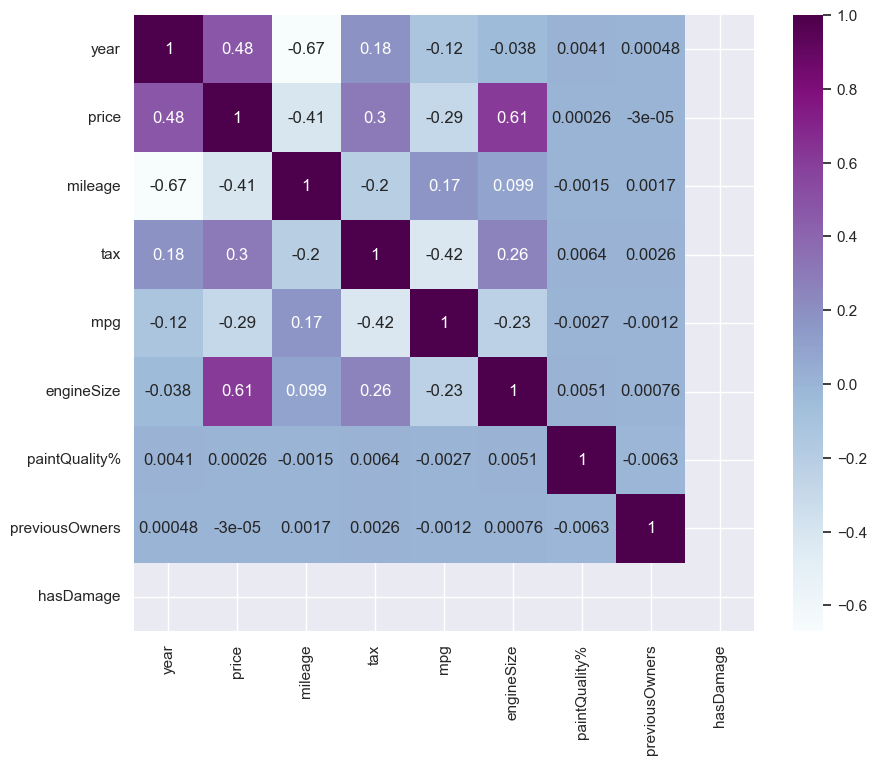

In [11]:
# correlation matrix -> to see feature redundance

correlation = numerical_data.corr() # default method is pearson correlation

plt.figure(figsize=(10,8))
sns.heatmap(data = correlation, annot = True, cmap="BuPu")
plt.show()

From this preleminary analysis there seems that features price and year and features price and engineSize have positive correlation (correlatio of 0.48 and 0.61 respectively), while features mileage and year; milage and price; and tax and mpg have negative correlation (-0.67, -0.41 and -0.42). These features could be important for the feature selection part since have ideial positive and negative correlation without having to high or to low of a correlation to make them irrelevant or redundant.

#### Categorical variables 

-> Barplots so see any inconsistencies in the data

In [13]:
categorical_data = train_car_data.select_dtypes(include="object")
categorical_cols = categorical_data.columns

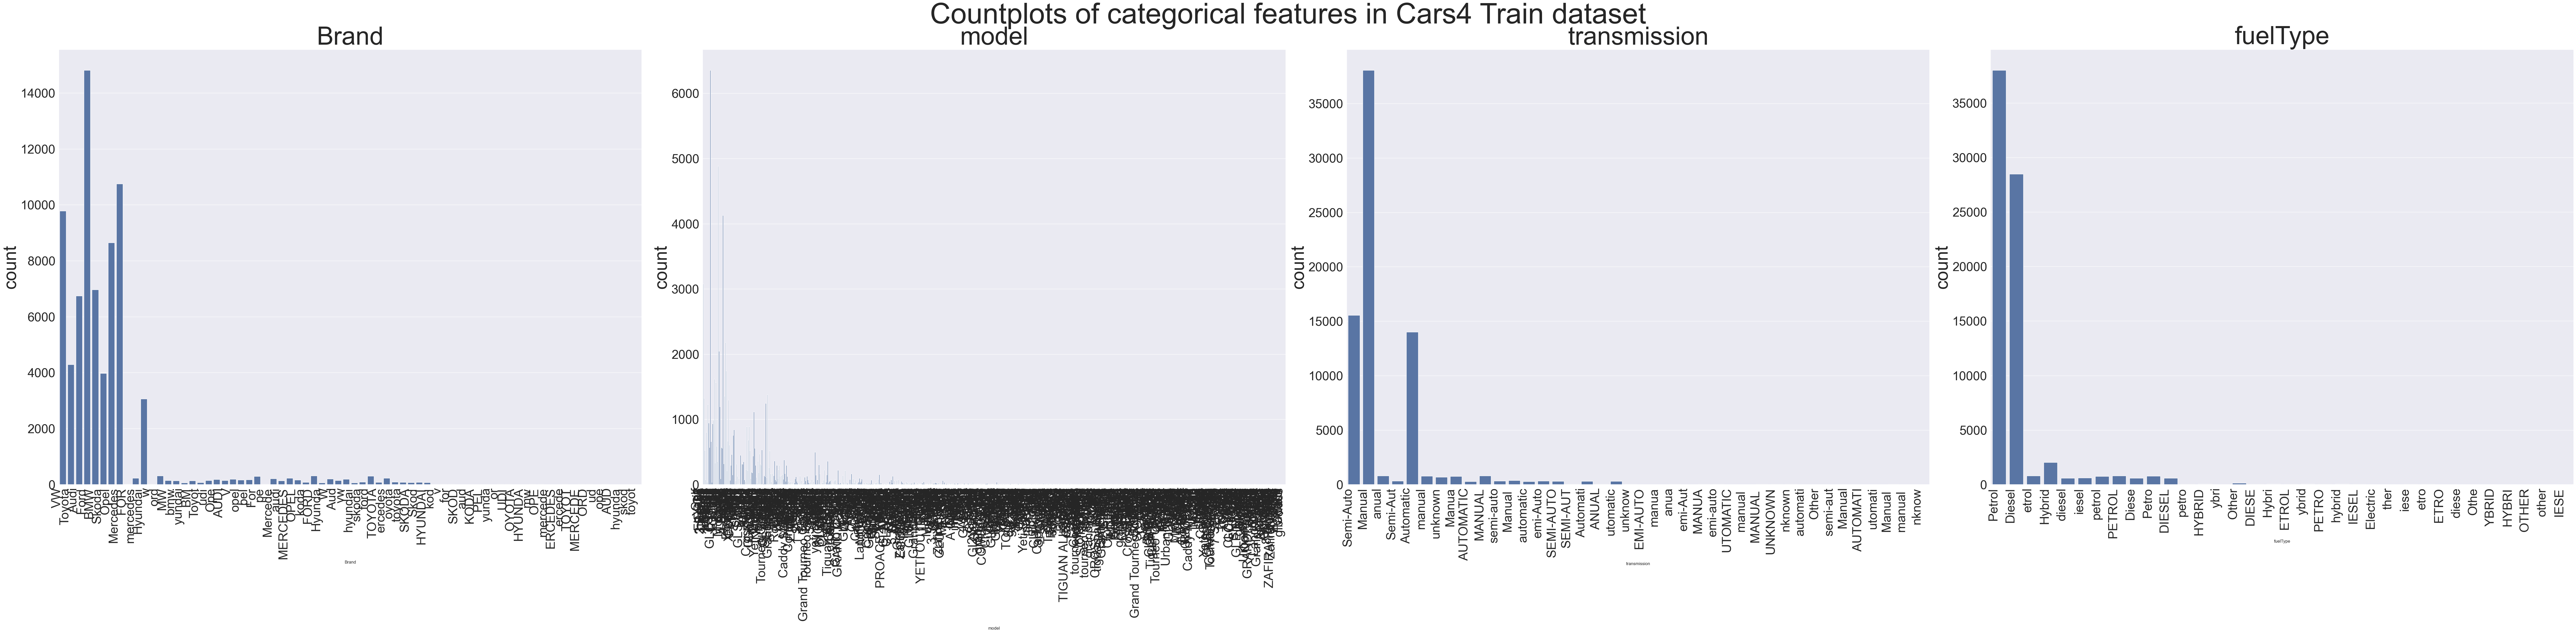

In [14]:
sns.set()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(100, 25), tight_layout=True)

for ax, feature in zip(axes.flatten(), categorical_cols):
    sns.countplot(data=categorical_data, x=feature, ax=ax)
    ax.set_title(feature, fontsize=70, pad=8)

    ax.set_ylabel("count", fontsize=50)

    ax.tick_params(axis='both', labelsize=35)

    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')


fig.set_constrained_layout_pads(wspace=0.1, hspace=0.15, w_pad=0.4, h_pad=0.3)
plt.suptitle("Countplots of categorical features in Cars4 Train dataset", fontsize=80)
plt.show()

In all categorical features there are data inconsistencies(a lot of names are misspelled). We need to address these inconsistencies in part 2.

### 2º part- Clean and pre-process the dataset
In this part we need to check for:

1. Are there any missing values? Take action to handle them.
2. Check the dataset for outliers and pre-process them. Justify your decisions.
3. Deal with categorical variables.
4. Review current features and create extra features if needed. Explain your steps.
5. Perform data scaling. Explain the reasoning behind your choices.

Before the preprocessing of the training dataset we are going to slipt the data into train and validation. After the slipt all the preprocessing is going to be done in the X_train and X_val data:

- Missing values: we are going to compute the imputation statistics (mean or median, depending on the feature) on X_train and use those same values to fill X_valid and X_test.
- Outliers: define limits for the outliers on X_train and apply the same caps to X_valid and X_test
- Categorical: Encode them in X_train and apply the same enconde in X_valid and X_test.
- Scaling: fit the scaler on X_train; transform X_valid/X_test with that fitted scaler.

In [19]:
# slipt the data into train and validation data

X = train_car_data.copy()
X = train_car_data.drop(["carID", "price"], axis=1) # contains all the features except the Ids and the target (Price)

y = train_car_data.copy()
y = train_car_data["price"] # only contains the target

In [20]:
X

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,VW,Golf,2016.0,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,Toyota,Yaris,2019.0,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,Audi,Q2,2019.0,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,Ford,FIESTA,2018.0,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,BMW,2 Series,2019.0,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
75968,Mercedes,C Class,2015.0,Manual,14480.0,etrol,125.0,53.300000,2.0,78.0,0.000000,0.0
75969,Audi,Q3,2013.0,Semi-Auto,52134.0,Diesel,200.0,47.900000,2.0,38.0,2.000000,0.0
75970,Toyota,Aygo,2017.0,Automatic,11304.0,Petrol,145.0,67.000000,1.0,57.0,3.000000,0.0
75971,Audi,Q3,2015.0,Manual,69072.0,iesel,125.0,60.100000,2.0,74.0,2.000000,0.0


In [21]:
y # X and y have the same number of rows

0        22290
1        13790
2        24990
3        12500
4        22995
         ...  
75968    13498
75969    12495
75970     8399
75971    12990
75972    10495
Name: price, Length: 75973, dtype: int64

In [106]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,   # reproducible split
    shuffle=True
)

In [107]:
X_test = test_car_data.copy()
X_test = X_test.set_index("carID")
X_test

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
105775,VW,Tiguan,2017.000000,Manual,27575.000000,Petrol,145.0,46.3,1.4,94.0,1.0,0.0
81363,BMW,X2,2020.000000,Automatic,1980.000000,Petrol,145.0,34.0,2.0,39.0,3.0,0.0
76833,Audi,Q5,2019.000000,Semi-Auto,8297.000000,Diesel,145.0,38.2,2.0,88.0,4.0,0.0


In [108]:
print(f"Shapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"Targets -> y_train: {y_train.shape}, y_val: {y_val.shape}")

Shapes -> X_train: (60778, 12), X_val: (15195, 12), X_test: (32567, 12)
Targets -> y_train: (60778,), y_val: (15195,)


#### Missing values on X_train, X_val and X_test 

In [109]:
# see the amount of missing values in each feature (X_train)
X_train.isna().sum()

Brand             1219
model             1196
year              1200
transmission      1231
mileage           1158
fuelType          1166
tax               6361
mpg               6360
engineSize        1227
paintQuality%     1217
previousOwners    1206
hasDamage         1237
dtype: int64

Every feature has missing data, so it's not the best decision to remove all the rows that have missing values beacuse we are going to loss a lot of information and data. As previosly mention, the missing values of the numeric features year, mileage, tax, mpg, and engineSize are going to be filled by the median, whereas the missing values of paintQuality% and previousOwners  are going to be replaced with the mean. Finally, hasDamage missing values are going to be replaced by 0.

#### Deal with numerical missing values 

In [110]:
num_data = X_train.select_dtypes(exclude="object")
num_col = num_data.columns
num_col

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage'],
      dtype='object')

In [111]:
for feature in num_col:
    if feature in ["year", "mileage", "tax", "mpg", "engineSize"]:
        train_median = X_train[feature].median()
        
        X_train[feature].fillna(train_median, inplace=True)
        # fill the missing values in X_val and X_test with the X_train median
        X_val[feature].fillna(train_median, inplace=True)
        X_test[feature].fillna(train_median, inplace=True)

    elif feature in ["paintQuality%", "previousOwners"]:
        train_mean = X_train[feature].mean()

        X_train[feature].fillna(train_mean, inplace=True)
        # fill the missing values in X_val and X_test with the X_train mean
        X_val[feature].fillna(train_mean, inplace=True)
        X_test[feature].fillna(train_mean, inplace=True)

    elif feature in ["hasDamage"]:
        X_train[feature].fillna(0, inplace=True)
        X_val[feature].fillna(0, inplace=True)
        X_test[feature].fillna(0, inplace=True)


/var/folders/f0/h1r1t1l15cz_0gjkxj_2n_qr0000gn/T/ipykernel_15279/1424290844.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[feature].fillna(train_median, inplace=True)
/var/folders/f0/h1r1t1l15cz_0gjkxj_2n_qr0000gn/T/ipykernel_15279/1424290844.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [112]:
X_train.isna().sum()

Brand             1219
model             1196
year                 0
transmission      1231
mileage              0
fuelType          1166
tax                  0
mpg                  0
engineSize           0
paintQuality%        0
previousOwners       0
hasDamage            0
dtype: int64

In [113]:
X_val.isna().sum()

Brand             302
model             321
year                0
transmission      291
mileage             0
fuelType          345
tax                 0
mpg                 0
engineSize          0
paintQuality%       0
previousOwners      0
hasDamage           0
dtype: int64

In [114]:
X_test.isna().sum()

Brand             649
model             650
year                0
transmission      623
mileage             0
fuelType          656
tax                 0
mpg                 0
engineSize          0
paintQuality%       0
previousOwners      0
hasDamage           0
dtype: int64

#### Deal with Categorical missing values and data inconsitencies

##### 1º Data inconsistencies

In [115]:
cat_col = X_train.select_dtypes(include="object").columns
cat_col

Index(['Brand', 'model', 'transmission', 'fuelType'], dtype='object')

In [116]:
# Frist lets check for data inconsistency

for category in cat_col:
    print(category)
    print(X_train[category].unique())

Brand
['Ford' 'Opel' 'Toyota' 'Audi' 'ord' 'ford' 'vw' 'BMW' 'VW' 'Skoda'
 'Mercedes' nan 'W' 'BM' 'Hyundai' 'udi' 'HYUNDAI' 'For' 'Aud' 'ercedes'
 'Ope' 'bmw' 'OPEL' 'MERCEDES' 'FORD' 'TOYOTA' 'Mercede' 'opel' 'AUDI' 'V'
 'skoda' 'toyota' 'SKODA' 'mercedes' 'oyota' 'audi' 'pel' 'Toyot'
 'hyundai' 'MW' 'Skod' 'toyot' 'Hyunda' 'hyunda' 'koda' 'KODA' 'ercede'
 'yundai' 'HYUNDA' 'FOR' 'ud' 'or' 'yunda' 'UDI' 'for' 'v' 'mw' 'ERCEDES'
 'PEL' 'ope' 'aud' 'OPE' 'SKOD' 'ORD' 'kod' 'pe' 'w' 'AUD' 'MERCEDE'
 'OYOTA' 'skod' 'mercede']
model
[' Fiesta' ' Mokka X' ' Yaris' 'Corsa' ' Q3' ' Focus' ' Q2' ' EcoSport'
 ' Polo' ' 4 Series' 'Up' ' Roomster' ' Up' ' Meriva' ' Golf' ' C Class'
 ' E Class' ' A Class' ' Insignia' ' X1' ' A5' ' A3' ' A4' ' Zafira'
 ' B Class' ' Mokka' ' Kuga' 'Karoq' ' Astra' ' V Class' ' Ka+'
 ' 1 Series' ' A1' ' RAV4' ' Scirocco' ' T-Roc' ' Kodiaq' ' Edge'
 ' Mondeo' ' Aygo' 'X1' ' A' ' Touran' ' 5 Series' nan ' insignia'
 ' 6 Series' ' 3 Series' ' Rapid' ' Tucson' ' Fiest' 

When checking the categorical features we can see a lot of inconsistances in the data:

- There are a lot of brand that are wrong (ex: mercedes, MERCEDES, ERCEDES, mercede, etc)
- In the model feature we have nan (we need to swap them for "Unkown")
- In the transmission and Fueltype we also have a lot of inconsistances

##### We can deal with this inconsistancies with fuzzy matching

In [117]:
def normalize_string(string: str) -> str:
    string = str(string).lower().strip()
    return re.sub(r"[^a-z0-9]+", "", string) # removes spaces


def fuzzy_fix(x: object, correct_names: Sequence[str], aliases: Optional[Mapping[str, str]] = None,  cutoff: int = 80):

    # creates a dict with the normalized strings as the keys and the not normalized strings as values from the input list
    canon_map = {normalize_string(label): label for label in correct_names}
    # create a list with only the keys (normalized strings)
    choice_keys = list(canon_map.keys())

    normalized_name = normalize_string(x)

    # Normalize alias keys too; alias values should be canonical brands
    if aliases:
        alias_normalized = {normalize_string(key): value for key, value in aliases.items()}
        if normalized_name in alias_normalized:
            return alias_normalized[normalized_name]

    # if the normalized string is already the correct name return it
    if normalized_name in canon_map:
        return canon_map[normalized_name]

    # it the normalized string doesn't correct to the correct name the use fuzzy match to match the name to the correct one
    match = process.extractOne(normalized_name, choice_keys, scorer=fuzz.WRatio, score_cutoff=cutoff)
    return canon_map[match[0]] if match else np.nan # returns the match with the highest similarity score

In [118]:
# Handle data inconsistencies in X_Train
# -----------------------
# Brands
# -----------------------
brands_list = ["Volkswagen", "Toyota", "Audi", "Ford", "BMW", "Skoda", "Opel", "Mercedes", "Hyundai"]
brands_aliases = {"vw":"Volkswagen","v":"Volkswagen","w": "Volkswagen", "merc":"Mercedes","bm":"BMW"}

X_train["Brand"] = X_train["Brand"].map(lambda brand: fuzzy_fix(brand, brands_list, brands_aliases, cutoff=84))
print(X_train["Brand"].unique())

# -----------------------
# transmissions
# -----------------------
transmissions_list = ["Manual", "Automatic", "Semi-Automatic", "Other", "Unkown"]
transmissions_alises = {"mt":"Manual", "man":"Manual", "auto":"Automatic", "at":"Automatic", "dsg":"Automatic"}

X_train["transmission"] = X_train["transmission"].map(lambda transmission: fuzzy_fix(transmission, transmissions_list, transmissions_alises, cutoff=82))
print(X_train["transmission"].unique())

# -----------------------
# fuelType
# -----------------------
fueltype_list = ["Petrol", "Diesel", "Hybrid", "Other"]

X_train["fuelType"] = X_train["fuelType"].map(lambda fueltype: fuzzy_fix(fueltype, fueltype_list, cutoff=82))
print(X_train["fuelType"].unique())

['Ford' 'Opel' 'Toyota' 'Audi' 'Volkswagen' 'BMW' 'Skoda' 'Mercedes' nan
 'Hyundai']
['Manual' 'Unkown' 'Automatic' 'Semi-Automatic' nan 'Other']
['Petrol' 'Hybrid' 'Diesel' 'Other' nan]


##### We need to do the same for X_val and X_test

In [119]:
# Handle data inconsistencies in X_val and X_test
# -----------------------
# Brands
# -----------------------
brands_list = ["Volkswagen", "Toyota", "Audi", "Ford", "BMW", "Skoda", "Opel", "Mercedes", "Hyundai"]
brands_aliases = {"vw":"Volkswagen","v":"Volkswagen","w": "Volkswagen", "merc":"Mercedes","bm":"BMW"}

X_val["Brand"] = X_val["Brand"].map(lambda brand: fuzzy_fix(brand, brands_list, brands_aliases, cutoff=84))
print("X_val brands:", X_val["Brand"].unique())

X_test["Brand"] = X_test["Brand"].map(lambda brand: fuzzy_fix(brand, brands_list, brands_aliases, cutoff=84))
print("X_test brands:",X_test["Brand"].unique())

# -----------------------
# transmissions
# -----------------------
transmissions_list = ["Manual", "Automatic", "Semi-Automatic", "Other", "Unkown"]
transmissions_alises = {"mt":"Manual", "man":"Manual", "auto":"Automatic", "at":"Automatic", "dsg":"Automatic"}

X_val["transmission"] = X_val["transmission"].map(lambda transmission: fuzzy_fix(transmission, transmissions_list, transmissions_alises, cutoff=82))
print("X_val transmission:",X_val["transmission"].unique())

X_test["transmission"] = X_test["transmission"].map(lambda transmission: fuzzy_fix(transmission, transmissions_list, transmissions_alises, cutoff=82))
print("X_test transmission:",X_test["transmission"].unique())

# -----------------------
# fuelType
# -----------------------
fueltype_list = ["Petrol", "Diesel", "Hybrid", "Other"]

X_val["fuelType"] = X_val["fuelType"].map(lambda fueltype: fuzzy_fix(fueltype, fueltype_list, cutoff=82))
print("X_val fuelType:",X_val["fuelType"].unique())

X_test["fuelType"] = X_test["fuelType"].map(lambda fueltype: fuzzy_fix(fueltype, fueltype_list, cutoff=82))
print("X_test fuelType:",X_test["fuelType"].unique())

X_val brands: ['Mercedes' 'Skoda' 'Volkswagen' 'Ford' 'Audi' 'BMW' 'Opel' 'Hyundai'
 'Toyota' nan]
X_test brands: ['Hyundai' 'Volkswagen' 'BMW' 'Opel' 'Ford' 'Mercedes' 'Skoda' 'Toyota'
 'Audi' nan]
X_val transmission: ['Automatic' 'Manual' 'Semi-Automatic' 'Unkown' nan]
X_test transmission: ['Automatic' 'Semi-Automatic' 'Manual' 'Unkown' nan 'Other']
X_val fuelType: ['Diesel' 'Petrol' 'Hybrid' nan 'Other']
X_test fuelType: ['Petrol' 'Diesel' 'Hybrid' nan 'Other']


For the car models the principle is the same but the we also need the car brand associated with the model

In [120]:
model_by_brand = {
    'Audi': ['A', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'Q', 'Q2', 'Q3', 'Q5', 'Q7', 'Q8', 'RS', 'RS3', 'RS4', 'RS5', 'RS6', 'S', 'S1', 'S3', 'S4', 'S5', 'S6', 'SQ2', 'SQ5', 'TT', 'e-tron'],
    'BMW': ['1 Series', '2 Series', '3 Serie', '3 SERIES', '3 Series', '4 Series', '5 Serie', '5 Series', '7 Series', '8 Series', 'M2', 'M3', 'M4', 'M5', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'Z4', 'i3', 'i4'],
    'Ford': ['B-MAX', 'C-MAX', 'Ecosport', 'Edge', 'Fiesta', 'Focus', 'Galaxy', 'Ka', 'Kuga', 'Mondeo', 'Mustang', 'Puma', 'S-MAX', 'Tourneo', 'Transit'],
    'Hyundai': ['Accent', 'Getz', 'I1', 'I10', 'I2', 'I20', 'I3', 'I30', 'I40', 'I80', 'I800', 'IONIQ', 'Kona', 'Santa Fe', 'Tucson'],
    'Mercedes': ['A-Class', 'AMG GT', 'B-Class', 'C-Class', 'CLA', 'CLK', 'CLS', 'Citan', 'E-Class', 'GLA', 'GLB', 'GLC', 'GLE', 'GLK', 'GLS', 'M-Class', 'S-Class', 'GLC-Class', 'SL', 'SLC', 'SLK', 'Sprinter', 'V-Class', 'Vaneo', 'Viano'],
    'Opel': ['Adam', 'Astra', 'Corsa', 'Crossland', 'Grandland', 'Insignia', 'Karl', 'Meriva', 'Mokka', 'Vectra', 'Zafira'],
    'Skoda': ['Citigo', 'Enyaq', 'Fabia', 'Kamiq', 'Karoq', 'Kodiaq', 'Octavia', 'Rapid', 'Roomster', 'Scala', 'Superb', 'Yeti'],
    'Toyota': ['Auris', 'Avensis', 'Aygo', 'C-HR', 'Camry', 'Corolla', 'GT86', 'RAV4', 'Verso', 'Yaris'],
    'Volkswagen': ['Arteon', 'Beetle', 'Bora', 'Caddy', 'CC', 'Crafter', 'Eos', 'Fox', 'Golf', 'Golf Plus', 'ID.3', 'ID.4', 'Jetta', 'Lupo', 'Passat', 'Phaeton', 'Polo', 'Scirocco', 'Sharan', 'T-Cross', 'T-Roc', 'Tiguan', 'Touareg', 'Touran', 'Transporter', 'Up'],
}


def fix_car_models(raw_model_names: str, cleaned_brand_names):

    candidates = model_by_brand.get(cleaned_brand_names)
    
    if not candidates:
        # fallback to all models if brand unknown
        candidates = sorted({m for lst in model_by_brand.values() for m in lst})
    
    # token_set_ratio handles word order/extra tokens well
    return fuzzy_fix(raw_model_names, candidates, aliases=None, cutoff=86)

In [121]:
# apply it on X_train
X_train["model"] = X_train.apply(lambda r: fix_car_models(r["model"], r["Brand"]), axis=1)
X_train["model"].unique()

array(['Fiesta', 'Mokka', 'Yaris', 'Corsa', 'Q3', 'Focus', 'Q2',
       'Ecosport', 'Polo', '4 Series', 'Up', 'Roomster', 'Meriva', 'Golf',
       'C-Class', 'E-Class', 'A-Class', 'Insignia', 'X1', 'A5', 'A3',
       'A4', 'Zafira', 'B-Class', 'Kuga', 'Karoq', 'Astra', 'V-Class',
       'Ka', '1 Series', 'A1', 'RAV4', 'Scirocco', 'T-Roc', 'Kodiaq',
       'Edge', 'Mondeo', 'Aygo', 'A', 'Touran', '5 Series', nan,
       '3 Series', 'Rapid', 'Tucson', 'C-MAX', '2 Series', 'Touareg',
       'GLC-Class', 'Superb', 'Q5', 'X5', 'I20', 'Tiguan', 'Citigo',
       'Yeti', 'C-HR', 'I10', 'Arteon', 'T-Cross', 'Galaxy', 'Octavia',
       'Fabia', 'Passat', 'A6', 'S3', 'CLA', 'S-Class', 'Santa Fe',
       'Crossland', 'I800', 'Corolla', 'Kona', 'TT', 'Auris', 'X3',
       'IONIQ', 'I30', 'Grandland', 'Kamiq', 'M-Class', 'Mustang',
       '5 Serie', 'Golf Plus', 'Q7', 'Adam', 'RS3', 'X2', 'Sharan',
       'B-MAX', 'M4', 'Scala', 'GT86', 'X4', 'RS5', 'Caddy', 'Z4',
       'Tourneo', 'Puma', 'A7', '8 

In [122]:
# Do the same for X_val and X_test
X_val["model"] = X_val.apply(lambda r: fix_car_models(r["model"], r["Brand"]), axis=1)
print("X_val car models:", X_val["model"].unique())

X_test["model"] = X_test.apply(lambda r: fix_car_models(r["model"], r["Brand"]), axis=1)
print("X_test car models:", X_test["model"].unique())

X_val car models: ['GLC-Class' 'C-Class' 'Citigo' 'Touareg' 'Focus' 'A1' 'Tiguan' 'Fiesta'
 '4 Series' 'Superb' nan 'Golf' 'Insignia' 'Polo' 'Zafira' 'Astra'
 'Ecosport' 'Meriva' 'Adam' '3 Series' 'A4' 'E-Class' 'A3' 'Crossland'
 'X3' 'Q2' 'CLA' 'Q5' 'S3' 'X5' 'Kuga' 'B-MAX' 'T-Roc' 'Tucson' 'Mokka'
 'A-Class' 'A' 'Up' 'I40' '2 Series' 'Kona' 'TT' 'Golf Plus' 'A5'
 '5 Series' 'C-HR' 'I10' 'C-MAX' 'Yaris' 'Q3' 'Auris' 'I30' 'Fabia'
 'T-Cross' 'Passat' 'X1' 'Corsa' 'Q7' 'Edge' 'B-Class' 'Scirocco'
 '1 Series' 'Verso' 'S-MAX' 'Aygo' 'Corolla' 'Ka' 'Galaxy' 'RAV4' 'I20'
 'IONIQ' 'Puma' 'Octavia' 'A6' 'Sharan' 'Kamiq' 'Grandland' 'M4'
 '7 Series' 'Scala' 'Yeti' 'SLK' 'Rapid' 'Mustang' 'Kodiaq' 'Karoq' 'I800'
 'S-Class' 'Avensis' 'A8' 'X4' 'Tourneo' 'Beetle' 'X2' 'Mondeo' 'Arteon'
 'Touran' 'Q' 'RS3' 'RS5' 'V-Class' 'RS6' 'X7' 'i3' '5 Serie' 'Caddy' 'X6'
 'Q8' 'M2' 'Getz' 'S4' 'Z4' 'A7' 'Roomster' 'CC' 'Santa Fe' 'GT86'
 '3 Serie' 'SQ5' 'Jetta' 'I1' '8 Series' 'RS4' 'M-Class' 'M5' 'Accent'
 

##### 2º missing values in categorical variables
For the missing values we can replace them with Unkown in the brand name, transmission and model and Other in the fuelType

In [123]:
for col in cat_col:
    if col in ["Brand", "model", "transmission"]:
        X_train[col].fillna("Unkown", inplace=True)
        X_val[col].fillna("Unkown", inplace=True)
        X_test[col].fillna("Unkown", inplace=True)
    else:
        X_train[col].fillna("Other", inplace=True)
        X_val[col].fillna("Other", inplace=True)
        X_test[col].fillna("Other", inplace=True)

/var/folders/f0/h1r1t1l15cz_0gjkxj_2n_qr0000gn/T/ipykernel_15279/107290510.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna("Unkown", inplace=True)
/var/folders/f0/h1r1t1l15cz_0gjkxj_2n_qr0000gn/T/ipykernel_15279/107290510.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

In [124]:
print("X_train missing values:\n", X_train.isna().sum())
print("X_val missing values:\n", X_val.isna().sum())
print("X_test missing values:\n", X_test.isna().sum())

X_train missing values:
 Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
hasDamage         0
dtype: int64
X_val missing values:
 Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
hasDamage         0
dtype: int64
X_test missing values:
 Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
hasDamage         0
dtype: int64


#### Handling outliers

As previously stated, most of the numerical variables have a significant number of outliers. One possibility is to calculate the interquartile range (iqr) and define the minimum and maximum tresholds, however this could result in the elimination of a lot of information. For this reason we can apply a mask and define the treshold ourself. 

-> As a rule of thumb we shouldn't delete more than 5% of the rows

However, instead of removing rows based on limit we can set some outliers to zero (in the case of negative values in milage, tax, etc) and then use a RobustScaler to strandardized and scale the data.

In [125]:
limits = {
    "mileage":        (0,      150000),
    "tax":            (0,      300),
    "mpg":            (0,      150),
    "engineSize":     (0,      5),
    "previousOwners": (0,      None),
}

def clip_to_limits(df: pd.DataFrame, limits: dict) -> pd.DataFrame:
    df_copy = df.copy()
    for col, (low, high) in limits.items():
        if col not in df_copy.columns:
            continue
        if low is not None:
            df_copy[col] = np.where(df_copy[col] < low, low, df_copy[col])
        if high is not None:
            df_copy[col] = np.where(df_copy[col] > high, high, df_copy[col])
    return df_copy

X_train = clip_to_limits(X_train, limits)
X_val = clip_to_limits(X_val, limits)
X_test  = clip_to_limits(X_test,  limits)

#### Data Encoding

We need to change the categorical data into numerical because the model only accepts numerical inputs. For this task we are going to use the different preprocessing methods from skicitlearn.

-> For the brand, transmission and fuelType we can use the OneHotEncoder because the number fo different brands, transmission and types of fuels is low so the creation columns for each new category isn't enough to cause the curse of dimensionality.

-> For the models, we can't use the OneHotEncoder beacuse of the curse of dimensionality, beacuse we were creating a significant amount of new columns. For these reason we are going to use a frequency encoder that maps each category to its frequency in the data. We choose this model because has low likage risk. 

In [126]:
ohe_cols = ["Brand", "transmission", "fuelType"]
freq_col = "model"

# Fit frequency encoder and OHE on X_train 

frequency_encoder = ce.CountEncoder(cols=[freq_col], normalize=True)
frequency_encoder.fit(X_train[[freq_col]])

one_hot_encoder = OneHotEncoder(
    drop="first",
    handle_unknown="ignore",  
    sparse_output=False
)
one_hot_encoder.fit(X_train[ohe_cols])

# Transform frequency-encoded column for all datsets
train_model_freq = frequency_encoder.transform(X_train[[freq_col]])[freq_col].rename("model_freq")
val_model_freq = frequency_encoder.transform(X_val[[freq_col]])[freq_col].rename("model_freq")
test_model_freq  = frequency_encoder.transform(X_test[[freq_col]])[freq_col].rename("model_freq")

# Transform OHE for Brand, transmission and fuelType for all datasets
train_ohe = one_hot_encoder.transform(X_train[ohe_cols])
val_ohe = one_hot_encoder.transform(X_val[ohe_cols])
test_ohe  = one_hot_encoder.transform(X_test[ohe_cols])

ohe_names = one_hot_encoder.get_feature_names_out(ohe_cols)

df_train_ohe = pd.DataFrame(train_ohe, columns=ohe_names, index=X_train.index)
df_val_ohe = pd.DataFrame(val_ohe, columns=ohe_names, index=X_val.index)
df_test_ohe  = pd.DataFrame(test_ohe,  columns=ohe_names, index=X_test.index)

# Concate the encoders DataFrames (drop original categorical cols and keep everything else)
drop_cols = ohe_cols + [freq_col]

X_train_enc = pd.concat(
    [X_train.drop(columns=drop_cols), df_train_ohe, train_model_freq],
    axis=1
)

X_val_enc = pd.concat(
    [X_val.drop(columns=drop_cols), df_val_ohe, val_model_freq],
    axis=1
)

X_test_enc = pd.concat(
    [X_test.drop(columns=drop_cols), df_test_ohe, test_model_freq],
    axis=1
)

In [127]:
X_train_enc.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_BMW,Brand_Ford,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
14554,2018.0,25943.0,145.0,65.7,1.0,34.0,1.000000,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.059035
72454,2018.0,28993.0,145.0,47.1,1.4,60.0,4.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.026819
30216,2014.0,66158.0,0.0,76.3,1.5,97.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.018856
52505,2017.0,22759.0,145.0,55.4,1.4,69.0,1.996337,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.030784
13506,2018.0,4847.0,145.0,40.4,2.0,51.0,4.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.012982


In [128]:
X_train_enc.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage', 'Brand_BMW', 'Brand_Ford',
       'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel', 'Brand_Skoda',
       'Brand_Toyota', 'Brand_Unkown', 'Brand_Volkswagen',
       'transmission_Manual', 'transmission_Other',
       'transmission_Semi-Automatic', 'transmission_Unkown', 'fuelType_Hybrid',
       'fuelType_Other', 'fuelType_Petrol', 'model_freq'],
      dtype='object')

In [129]:
X_val_enc.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_BMW,Brand_Ford,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
69512,2018.0,9500.0,150.0,56.5,2.1,77.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010037
53000,2017.0,50369.0,20.0,65.7,2.1,80.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074122
6366,2017.0,7489.0,150.0,64.2,1.0,84.0,4.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.004179
29021,2019.0,7000.0,145.0,34.0,3.0,62.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003406
10062,2019.0,10812.0,145.0,54.3,1.5,99.0,2.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092237


In [130]:
X_test_enc.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_BMW,Brand_Ford,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
carID,,,,,,,,,,,,,,,,,,,,,
89856,2022.878006,30700.0,205.0,41.5,1.6,61.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.004821
106581,2017.000000,0.0,150.0,38.2,2.0,60.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.016963
80886,2016.000000,36792.0,125.0,51.4,1.5,94.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.011057
100174,2019.000000,5533.0,145.0,44.1,1.2,77.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.005002
81376,2019.000000,9058.0,150.0,51.4,2.0,45.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.017967


#### Data scaling
As previously mentioned we are going to use the RobustScaler from scikitlearn, beauce is more robust to outliers since is based on median/iqr

In [131]:
robust_scaler = RobustScaler()

# Fit and transformt the train data (only transform the validation and test data)
X_train_scaled = robust_scaler.fit_transform(X_train_enc) 
X_val_scaled = robust_scaler.transform(X_val_enc) 
X_test_scaled = robust_scaler.transform(X_test_enc) 

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_enc.columns, index=X_train_enc.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val_enc.columns, index=X_val_enc.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_enc.columns, index=X_test_enc.index)

In [132]:
X_train_scaled_df.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_BMW,Brand_Ford,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
14554,0.333333,0.355492,0.00,0.797203,-0.750,-0.876018,-0.500000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.081009
72454,0.333333,0.480182,0.00,-0.503497,-0.250,-0.133161,1.000000,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.214254
30216,-1.000000,1.999571,-7.25,1.538462,-0.125,0.923982,-0.500000,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.000000
52505,0.000000,0.225322,0.00,0.076923,-0.250,0.123982,-0.001831,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.320938
13506,0.333333,-0.506960,0.00,-0.972028,0.500,-0.390304,1.000000,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.158035


Some of the values are negative but that is expexted because they are below the median (above the median are positive).

In [133]:
X_val_scaled_df.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_BMW,Brand_Ford,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
69512,0.333333,-0.316735,0.25,0.153846,0.625,0.352553,-1.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.237273
53000,0.000000,1.354081,-6.25,0.797203,0.625,0.438267,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.486941
6366,0.000000,-0.398949,0.25,0.692308,-0.750,0.552553,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.394865
29021,0.666667,-0.418941,0.00,-1.419580,1.750,-0.076018,-1.0,0.0,0.0,0.0,...,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.415671
10062,0.666667,-0.263098,0.00,0.000000,-0.125,0.981125,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.974325


In [134]:
X_test_scaled_df.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_BMW,Brand_Ford,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
carID,,,,,,,,,,,,,,,,,,,,,
89856,1.959335,0.549968,3.00,-0.895105,0.000,-0.104590,0.5,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.377601
106581,0.000000,-0.705116,0.25,-1.125874,0.500,-0.133161,0.0,0.0,0.0,0.0,...,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.050907
80886,-0.333333,0.799023,-1.00,-0.202797,-0.125,0.838267,0.0,0.0,1.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.209827
100174,0.666667,-0.478915,0.00,-0.713287,-0.500,0.352553,-0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.372731
81376,0.666667,-0.334805,0.25,-0.202797,0.500,-0.561733,1.0,0.0,1.0,0.0,...,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,-1.0,-0.023904


### Part 3: Feature Selection

For the the feature selection part we can use different methods: filter methods, wrapper methods and embedded methods:

-> filter methods are especially helpful for making an initial screening of the datasets. However, due to their simplicity (they aren't based on a model) they are less affective that wrapper and embedded methods. Due to this reason, once possivel pipeline is to pass the features to different wrapper and embedded methods (one of each) and them selection the features that are more important based on theses methods.

-> For the wrpper methods we can use Recursive Feature Elimination (RFE) or even RFECV

-> Fot the embedded method we can use the Lasso Regression.

For this part we are going to only do feature selection on the train dataset, select the features to keep and them drop all the features that are not relevant or don't give information to the model, in the train. validation and test datasets

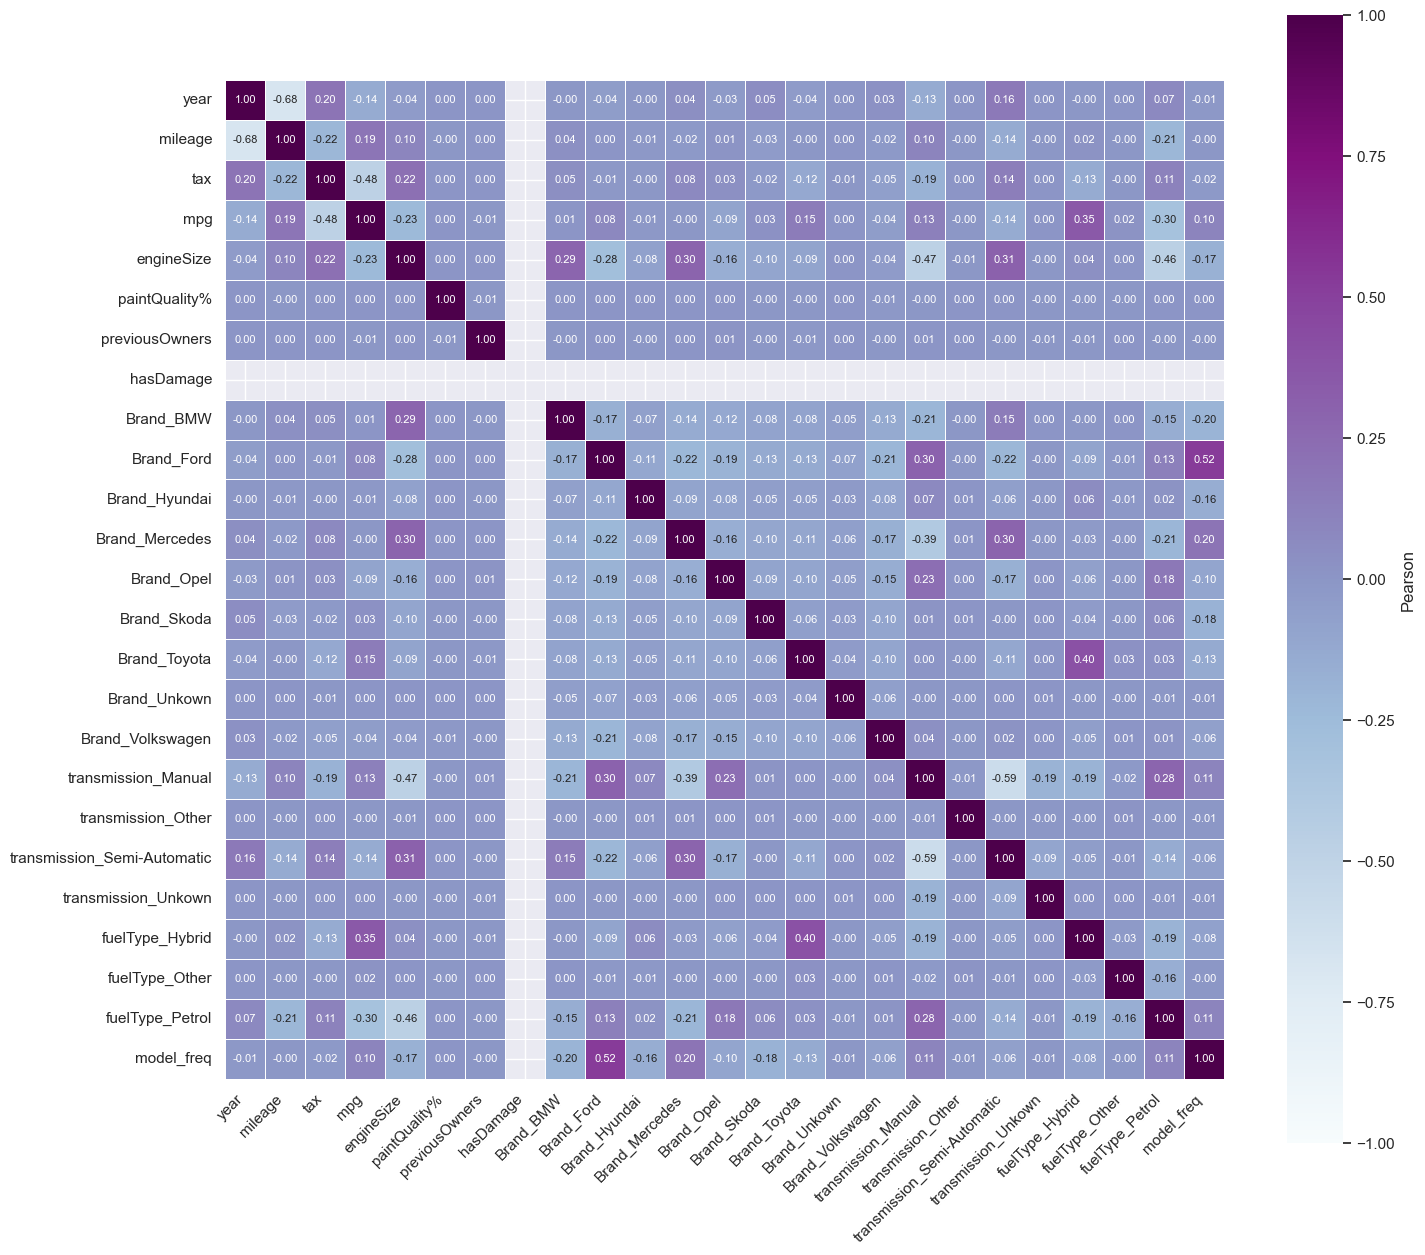

In [78]:
# Fiter method (pearson correlation)
correlations = X_train_scaled_df.corr() # default method is pearson correlation

plt.figure(figsize=(15, 15))
sns.heatmap(
    correlations, cmap="BuPu", vmin=-1, vmax=1,
    annot=True, fmt=".2f", annot_kws={"size":8},
    cbar_kws={"shrink":0.8, "label":"Pearson"},
    linewidths=0.5, linecolor="white", square=True
)
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

From the Correltion matrix it doesn't seems that we have redundant variants (variants with a very high absolute correlation). So we don´t need to drop any features.

-> The HasDamage feature doesn't have any correlation because is a column only composed of zeros, so the correlations are zero across features.

In [82]:
# wrapper method (RFECV)

# the model we are going to use is Random Forrest Regressor
    
estimator = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=1)   

rfecv = RFECV(
    estimator=estimator, 
    step=1, # In each step 2 features are removed
    cv=KFold(n_splits=5, shuffle=True, random_state=42), # split training data into 4 folds and randomly shuffle the rows before folding 
    scoring="neg_root_mean_squared_error", # higher scoring is better (less negative)
    min_features_to_select=7, # it stops when are only 7 features left
    n_jobs = -1 # -1 means using all processors
)

rfecv.fit(X_train_scaled_df, y_train)

# get the optimal number of features
print("Optimal number of features:", rfecv.n_features_)
selected_mask = rfecv.support_
selected_features = X_train_scaled_df.columns[selected_mask]
print("Selected features:", list(selected_features))

mean_cv_score = rfecv.cv_results_["mean_test_score"]  # mean score for each feature count (drop 1 features at a time)
print("mean_cv_score:", mean_cv_score)

Exception ignored in: <function ResourceTracker.__del__ at 0x105a8dc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104cb9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107075c60>
Traceback (most recent call last

Optimal number of features: 25
Selected features: ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage', 'Brand_BMW', 'Brand_Ford', 'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel', 'Brand_Skoda', 'Brand_Toyota', 'Brand_Unkown', 'Brand_Volkswagen', 'transmission_Manual', 'transmission_Other', 'transmission_Semi-Automatic', 'transmission_Unkown', 'fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol', 'model_freq']
mean_cv_score: [-2808.31810916 -2765.61479778 -2754.41438131 -2757.81647537
 -2749.2331279  -2713.30064352 -2665.97649501 -2647.12042291
 -2639.36995317 -2636.01163451 -2628.03782053 -2619.54267579
 -2612.88416789 -2614.05117767 -2609.90976121 -2607.30502747
 -2607.46136469 -2607.54929337 -2606.48711076]


In [84]:
# try RFE with the same estimator 

estimator = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = "neg_root_mean_squared_error"

range_features = np.arange(1,len(X_train_scaled_df.columns)+1)
scores = []

for k in range_features:
    rfe = RFE(estimator=estimator, n_features_to_select=k, step=5)
    # cross-validation on training data 
    cv_score = cross_val_score(rfe, X_train_scaled_df, y_train, cv=cv, scoring=scoring, n_jobs=-1).mean()
    scores.append(cv_score)
    print(f"k={k:>2}  mean CV (neg-RMSE) = {cv_score:.4f}")

# pick the best number of features
best_number_features = range_features[int(np.argmax(scores))]
print("Best number of features:", best_number_features)

# refit RFE on train data with best_k and extract features
rfe_best = RFE(estimator=estimator, n_features_to_select=best_number_features, step=3)
rfe_best.fit(X_train_scaled_df, y_train)
selected_features_2 = X_train_scaled_df.columns[rfe_best.support_]
print("Selected features:", list(selected_features_2))

k= 1  mean CV (neg-RMSE) = -8294.4480


Exception ignored in: <function ResourceTracker.__del__ at 0x107865c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k= 2  mean CV (neg-RMSE) = -6648.1200


Exception ignored in: <function ResourceTracker.__del__ at 0x1074bdc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10680dc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102751c60>
Traceback (most recent call last

k= 3  mean CV (neg-RMSE) = -4520.1449


Exception ignored in: <function ResourceTracker.__del__ at 0x1037d1c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102875c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k= 4  mean CV (neg-RMSE) = -4813.9929


Exception ignored in: <function ResourceTracker.__del__ at 0x104ee5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105811c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: 

k= 5  mean CV (neg-RMSE) = -3582.5036


Exception ignored in: <function ResourceTracker.__del__ at 0x108789c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1024b5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103875c60>
Traceback (most recent call last

k= 6  mean CV (neg-RMSE) = -2744.5149


Exception ignored in: <function ResourceTracker.__del__ at 0x105c65c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1035e9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10ca65c60>
Traceback (most recent call last

k= 7  mean CV (neg-RMSE) = -2808.3181


Exception ignored in: <function ResourceTracker.__del__ at 0x106e8dc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104b9dc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106d65c60>
Traceback (most recent call last

k= 8  mean CV (neg-RMSE) = -2765.6148


Exception ignored in: <function ResourceTracker.__del__ at 0x1071c9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104f1dc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k= 9  mean CV (neg-RMSE) = -2754.4144
k=10  mean CV (neg-RMSE) = -2730.1440


Exception ignored in: <function ResourceTracker.__del__ at 0x106fd1c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1067e9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=11  mean CV (neg-RMSE) = -2749.2331


Exception ignored in: <function ResourceTracker.__del__ at 0x102959c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=12  mean CV (neg-RMSE) = -2713.3006


Exception ignored in: <function ResourceTracker.__del__ at 0x1050a5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103de9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105091c60>
Traceback (most recent call last

k=13  mean CV (neg-RMSE) = -2665.9765
k=14  mean CV (neg-RMSE) = -2647.1204


Exception ignored in: <function ResourceTracker.__del__ at 0x104e59c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=15  mean CV (neg-RMSE) = -2639.3700


Exception ignored in: <function ResourceTracker.__del__ at 0x10552dc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110aa5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=16  mean CV (neg-RMSE) = -2636.0116


Exception ignored in: <function ResourceTracker.__del__ at 0x107265c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106725c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=17  mean CV (neg-RMSE) = -2628.0378


Exception ignored in: <function ResourceTracker.__del__ at 0x1135e5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106931c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1145e5c60>
Traceback (most recent call last

k=18  mean CV (neg-RMSE) = -2619.5427


Exception ignored in: <function ResourceTracker.__del__ at 0x1087e9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107f25c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=19  mean CV (neg-RMSE) = -2612.8842
k=20  mean CV (neg-RMSE) = -2614.5692
k=21  mean CV (neg-RMSE) = -2609.9098


Exception ignored in: <function ResourceTracker.__del__ at 0x10a265c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=22  mean CV (neg-RMSE) = -2607.3050
k=23  mean CV (neg-RMSE) = -2607.4614


Exception ignored in: <function ResourceTracker.__del__ at 0x10495dc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1026d9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=24  mean CV (neg-RMSE) = -2607.5493


Exception ignored in: <function ResourceTracker.__del__ at 0x102d3dc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1120bdc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105739c60>
Traceback (most recent call last

k=25  mean CV (neg-RMSE) = -2606.4871
Best number of features: 25
Selected features: ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage', 'Brand_BMW', 'Brand_Ford', 'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel', 'Brand_Skoda', 'Brand_Toyota', 'Brand_Unkown', 'Brand_Volkswagen', 'transmission_Manual', 'transmission_Other', 'transmission_Semi-Automatic', 'transmission_Unkown', 'fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol', 'model_freq']


In [85]:
# Embedded method with Lasso Regression

lasso_reg = LassoCV()

lasso_reg.fit(X_train_scaled_df, y_train)

coefficient = pd.Series(lasso_reg.coef_, index = X_train_scaled_df.columns)

print(coefficient.sort_values())
important_features = [coef for coef, val in coefficient.items() if not np.isclose(val, 0.0, atol=1e-6)]
print("Important features:", important_features)

features_to_discard = [coef for coef, val in coefficient.items() if np.isclose(val, 0.0, atol=1e-6)]
print("Features to discard:", features_to_discard)

Brand_Opel                    -6572.623642
Brand_Toyota                  -5584.258466
Brand_Hyundai                 -5234.864694
Brand_Skoda                   -4054.722363
Brand_Ford                    -3145.039929
Brand_Volkswagen              -2521.335739
mileage                       -2423.745006
transmission_Manual           -2146.622800
Brand_Unkown                  -2126.313425
mpg                           -1669.201964
Brand_BMW                     -1161.746174
transmission_Unkown            -828.050595
model_freq                     -206.617588
tax                             -45.837191
paintQuality%                   -30.808760
hasDamage                         0.000000
transmission_Other                0.000000
fuelType_Petrol                   0.000000
previousOwners                    6.120417
fuelType_Other                  112.049942
Brand_Mercedes                  448.999555
transmission_Semi-Automatic     588.355207
year                           3976.924709
fuelType_Hy

In [135]:
index = [col for col in X_train_scaled_df.columns]
index

['year',
 'mileage',
 'tax',
 'mpg',
 'engineSize',
 'paintQuality%',
 'previousOwners',
 'hasDamage',
 'Brand_BMW',
 'Brand_Ford',
 'Brand_Hyundai',
 'Brand_Mercedes',
 'Brand_Opel',
 'Brand_Skoda',
 'Brand_Toyota',
 'Brand_Unkown',
 'Brand_Volkswagen',
 'transmission_Manual',
 'transmission_Other',
 'transmission_Semi-Automatic',
 'transmission_Unkown',
 'fuelType_Hybrid',
 'fuelType_Other',
 'fuelType_Petrol',
 'model_freq']

In [136]:
data = {
    "Pearson": ["Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Discard", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep"],
    "RFECV": ["Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep"],
    "RFE": ["Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep"],
    "Lasso": ["Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Discard", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Discard", "Keep", "Keep", "Keep", "Keep", "Discard", "Keep"]
}

In [137]:
df_feature_selection = pd.DataFrame(
    data,
    index = index
)

df_feature_selection

,Pearson,RFECV,RFE,Lasso
year,Keep,Keep,Keep,Keep
mileage,Keep,Keep,Keep,Keep
tax,Keep,Keep,Keep,Keep
mpg,Keep,Keep,Keep,Keep
engineSize,Keep,Keep,Keep,Keep
paintQuality%,Keep,Keep,Keep,Keep
previousOwners,Keep,Keep,Keep,Keep
hasDamage,Discard,Keep,Keep,Discard
Brand_BMW,Keep,Keep,Keep,Keep
Brand_Ford,Keep,Keep,Keep,Keep


Regarding feature selection, both RFECV and RFE keept all feature, which as not expected since the hasDamage column only contains 0, while both the Pearson Correlation and the Lasso regression discarded that feature. Since hasDamage doesn't add information to the model we it can be discard.

The Lasso also discarded both the transmission_Other and fuelType_Petrol, however the other 3 methods choose to keep it. Since the majority decided to keep it we are going to keep this features.

In [138]:
selected_col = [col for col in X_train_scaled_df.columns if col != "hasDamage"]

In [139]:
X_train_fs = X_train_scaled_df[selected_col].copy()
X_val_fs = X_val_scaled_df[selected_col].copy()
X_test_fs = X_test_scaled_df[selected_col].copy()

In [140]:
X_train_fs.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,Brand_BMW,Brand_Ford,Brand_Hyundai,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
14554,0.333333,0.355492,0.00,0.797203,-0.750,-0.876018,-0.500000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.081009
72454,0.333333,0.480182,0.00,-0.503497,-0.250,-0.133161,1.000000,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.214254
30216,-1.000000,1.999571,-7.25,1.538462,-0.125,0.923982,-0.500000,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.000000
52505,0.000000,0.225322,0.00,0.076923,-0.250,0.123982,-0.001831,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.320938
13506,0.333333,-0.506960,0.00,-0.972028,0.500,-0.390304,1.000000,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.158035


In [141]:
X_val_fs.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,Brand_BMW,Brand_Ford,Brand_Hyundai,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
69512,0.333333,-0.316735,0.25,0.153846,0.625,0.352553,-1.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.237273
53000,0.000000,1.354081,-6.25,0.797203,0.625,0.438267,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.486941
6366,0.000000,-0.398949,0.25,0.692308,-0.750,0.552553,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.394865
29021,0.666667,-0.418941,0.00,-1.419580,1.750,-0.076018,-1.0,0.0,0.0,0.0,...,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.415671
10062,0.666667,-0.263098,0.00,0.000000,-0.125,0.981125,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.974325


In [142]:
X_test_fs.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,Brand_BMW,Brand_Ford,Brand_Hyundai,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
carID,,,,,,,,,,,,,,,,,,,,,
89856,1.959335,0.549968,3.00,-0.895105,0.000,-0.104590,0.5,0.0,0.0,1.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.377601
106581,0.000000,-0.705116,0.25,-1.125874,0.500,-0.133161,0.0,0.0,0.0,0.0,...,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.050907
80886,-0.333333,0.799023,-1.00,-0.202797,-0.125,0.838267,0.0,1.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.209827
100174,0.666667,-0.478915,0.00,-0.713287,-0.500,0.352553,-0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.372731
81376,0.666667,-0.334805,0.25,-0.202797,0.500,-0.561733,1.0,1.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,-1.0,-0.023904


### Part 4: Model Selection and Evaluation

This project represents a **regression** task: predicting car prices from multiple features, and for these reason we need to select different types of regression models. Some of the models we could try are:

- **Ordinary Least Squares (LinearRegression)**
- **RandomForestRegressor** (ensemble method)
- **Ridge Regression** – L2-regularized
- **Lasso Regression** – L1-regularized
- **Elastic Net** – mix of L1/L2;


Regarding the metrics used for model evaluation in regression problems we can use:

- **$R^{2}$** or **$R^{2}$ ajusted** scores
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean squared error)

#### 4.1) OLS evaluation

In [144]:
def evaluation_report(y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"R²: {r2:.4f} | MAE: {mae:,.2f} | RMSE: {rmse:,.2f}")

In [146]:
# test the model with the training and validation data

ols = LinearRegression()

# fit on the train data
ols.fit(X_train_fs, y_train)

# Predictions
y_pred_train = ols.predict(X_train_fs)
y_pred_valid = ols.predict(X_val_fs)

print("TRAIN performance:")
evaluation_report(y_train, y_pred_train)

print("\nVALIDATION performance:")
evaluation_report(y_val, y_pred_valid)

TRAIN performance:
R²: 0.7378 | MAE: 3,141.20 | RMSE: 5,009.84

VALIDATION performance:
R²: 0.7423 | MAE: 3,156.87 | RMSE: 4,844.40
